In [1]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import random
import GPy

GPy.plotting.change_plotting_library('matplotlib')

%cd "~/notebookh4g/"


/home/carlos/notebookh4g


Print the ArticleVersion of the items for which we have a time series

In [2]:
import glob, os
for file in glob.glob("*.csv"):
    print(file)



DORAFERF14T .csv
DINJCLOX5VV .csv
DORAALUM44TC .csv
DINJEPIN1AV .csv
DINFDEXT5FBF5 .csv
DINJARTS6V .csv
DORACEFI2T .csv
SDDCBAGP06P1 .csv
SDRECOTW5RT01 .csv
SDRECOMP1S .csv
DORADOXY1T .csv
DINJDEXA4A .csv
SDRECOMN7NT01 .csv
DORAARLU1TD1 .csv
DINJDICL7A .csv
DORAFOLA5T .csv
DINFDEXT1FBF5 .csv
DORAALBE4T .csv
DINJAMOC1V2 .csv
DINJAMPI1V .csv
DINJCEFT1V .csv
SDREBANE104 .csv
DORAAMOX1S1 .csv
DORAARLU2TD1 .csv
DEXTALCO5S .csv
DORAAMOX5T .csv
SDRETAPA1P5 .csv
DORACLOX2C .csv
DORACIPR5T .csv
STSSBSVT5E .csv
ELAEGLUT201 .csv
SDRETAPA025 .csv
DORAARLU4T1 .csv
ELAEHAET305 .csv
DORAAZIT2T .csv
DORAAMOC56T .csv
DEXTCLOT5T .csv


We plot the demand time series for the articles above (warnings are only about excesive memory usage for plotting).
Just scroll down to see the plots

 <ipython-input-34-fe8ebfa29eb1>:15: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 <ipython-input-34-fe8ebfa29eb1>:15: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 <ipython-input-34-fe8ebfa29eb1>:15: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 <ipython-input-34-fe8ebfa29eb1>:15: RuntimeWarning:More than 20 figures have been op

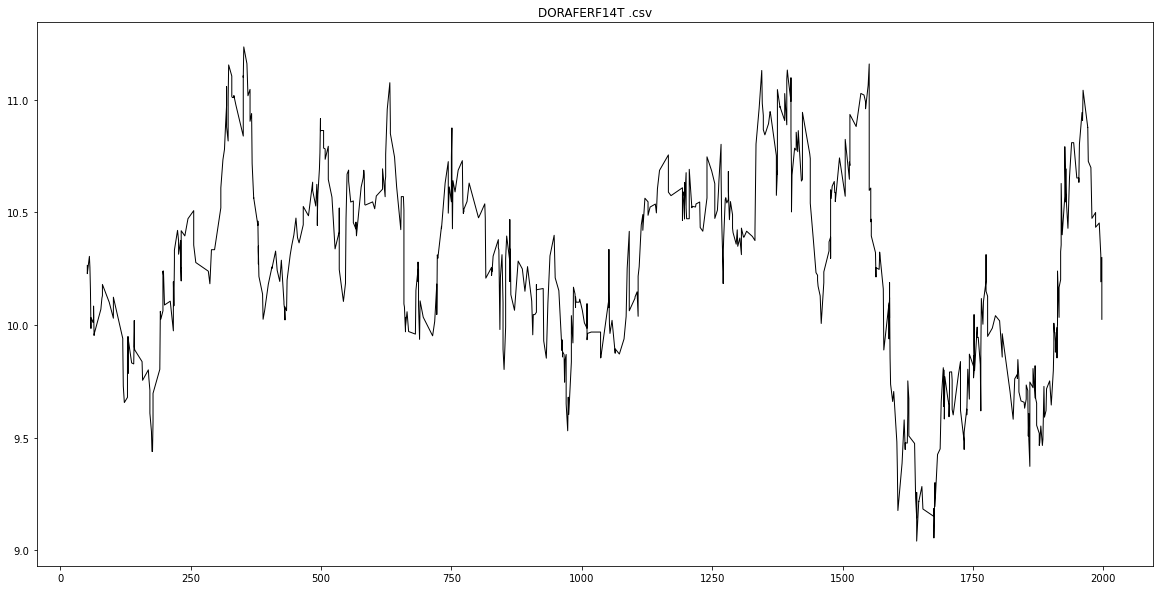

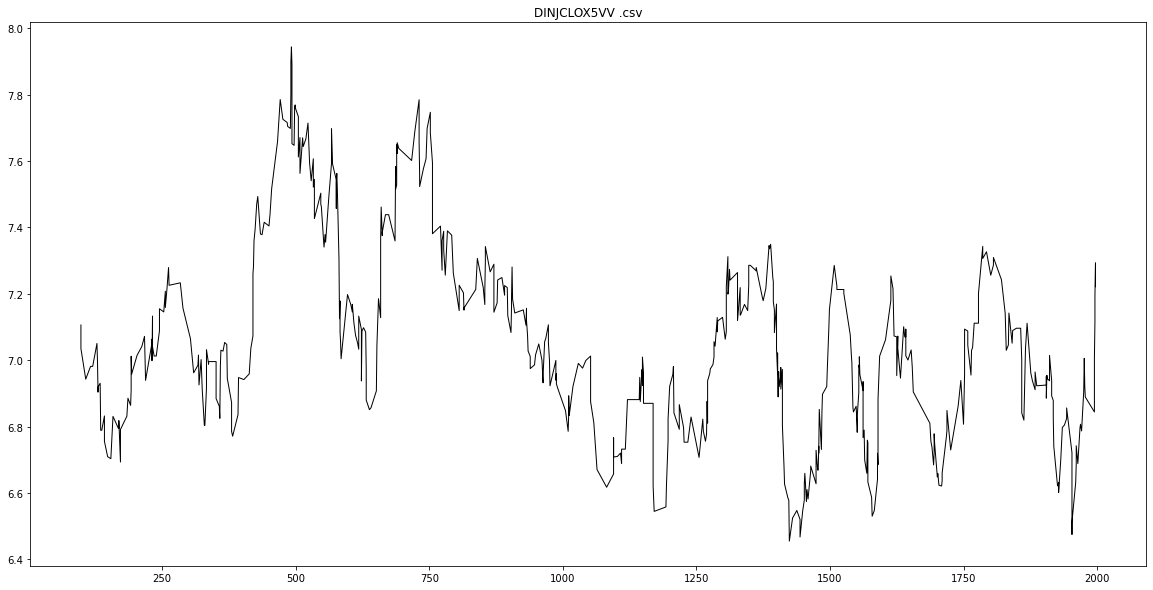

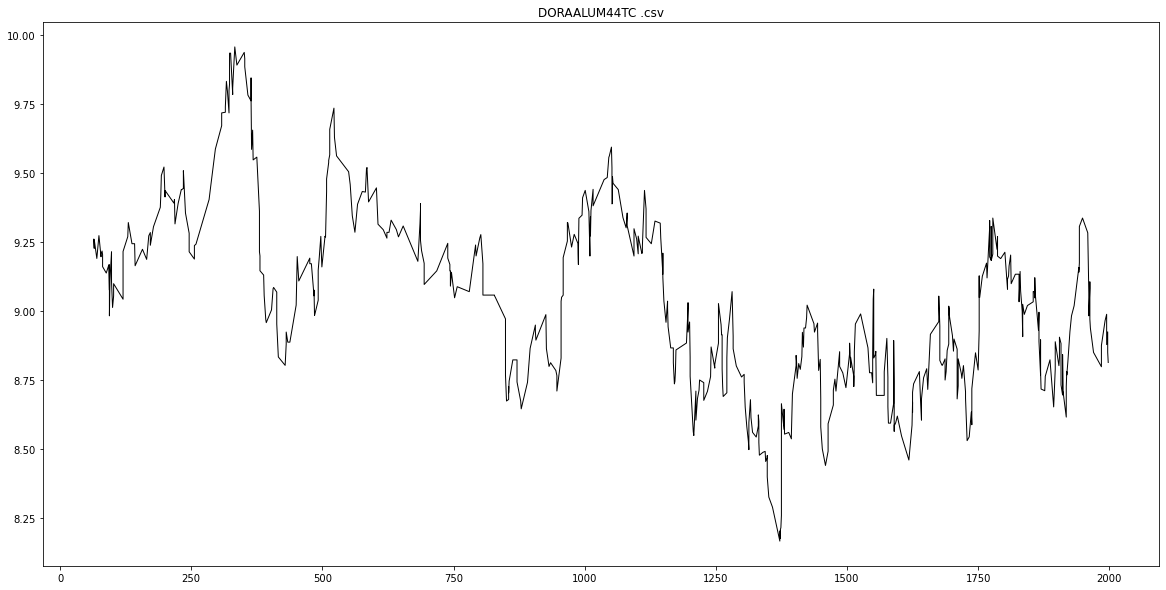

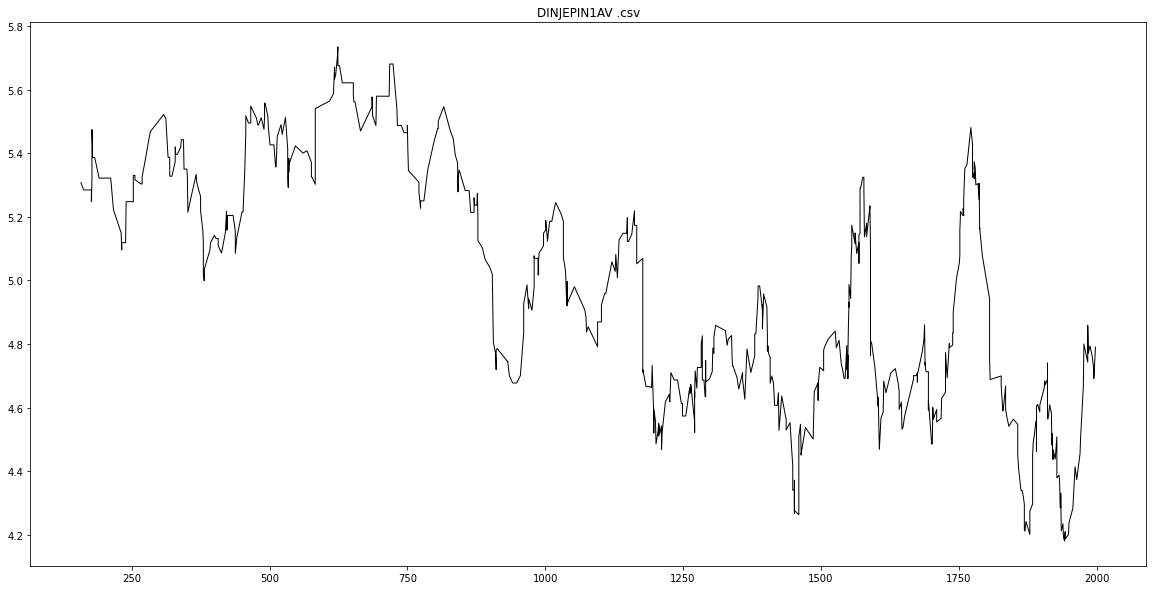

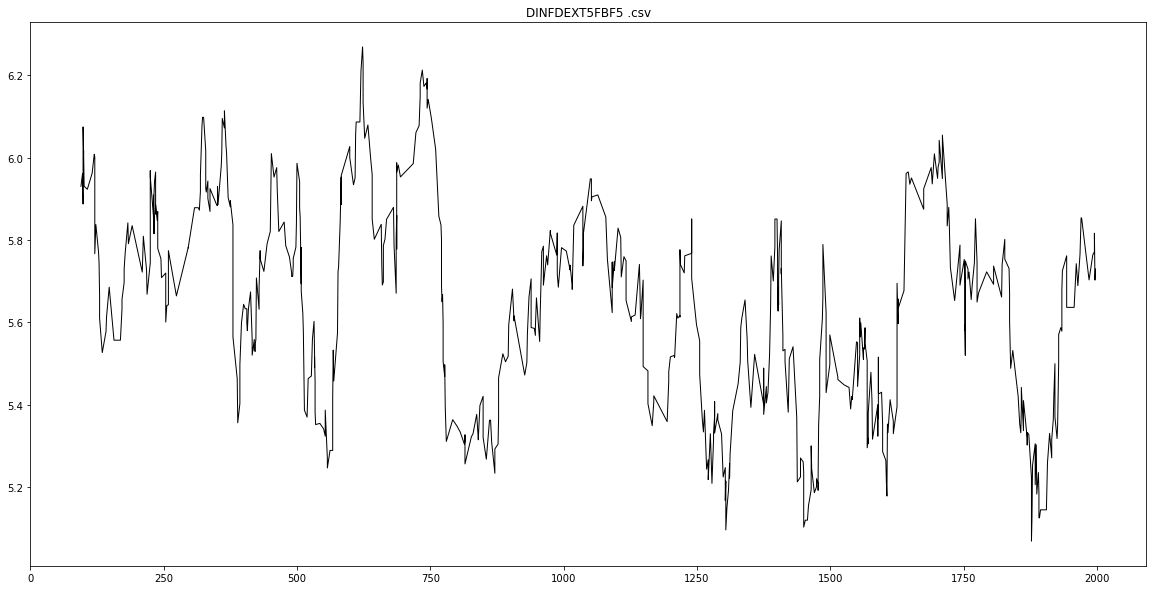

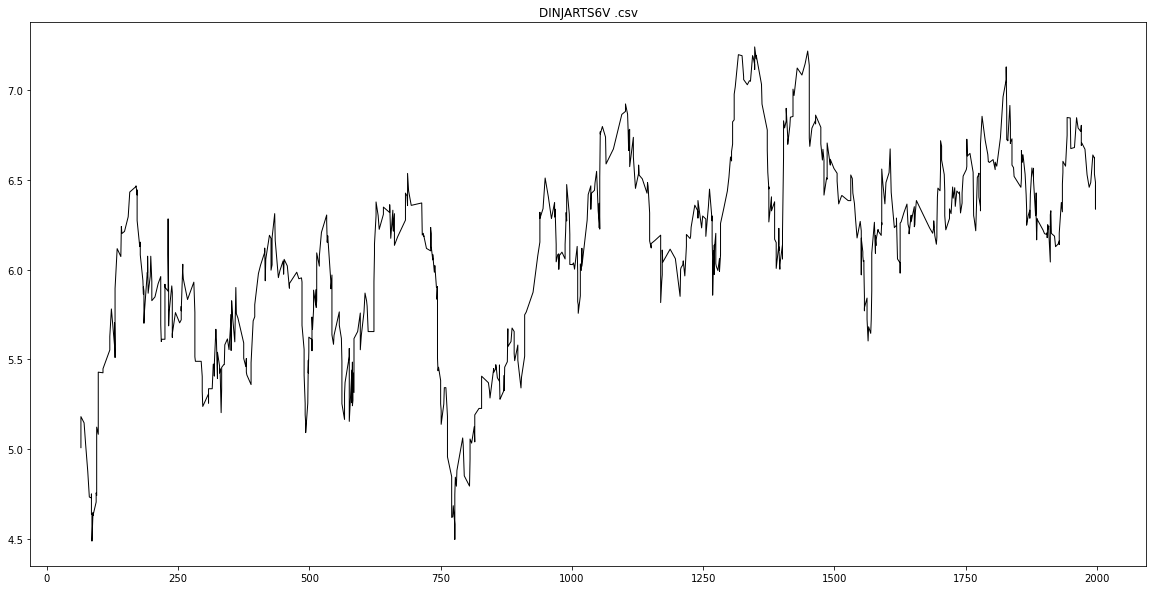

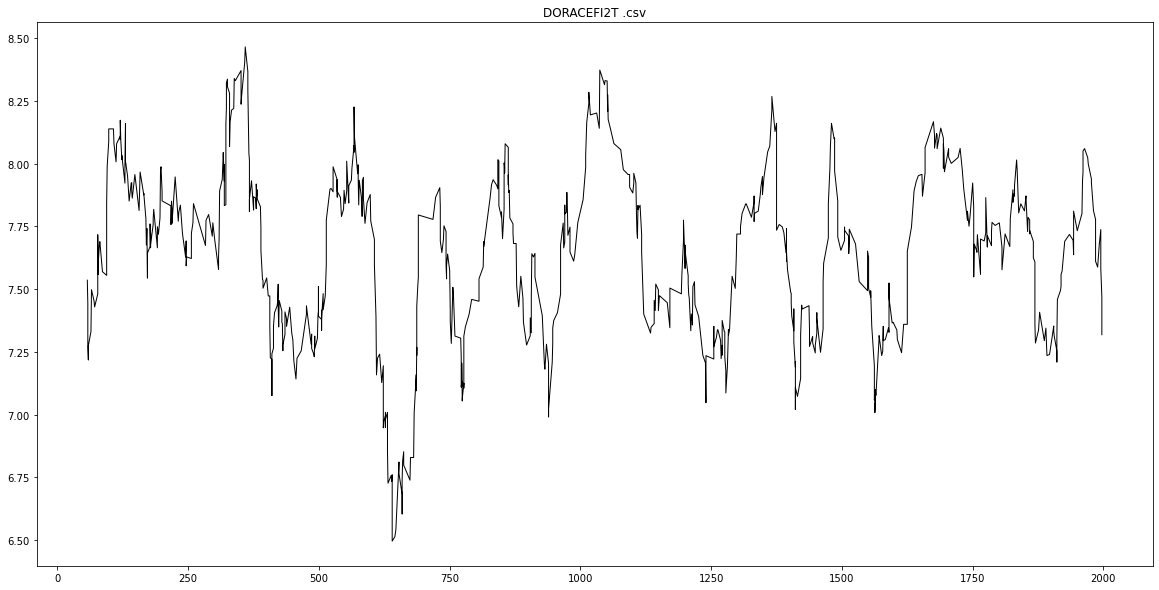

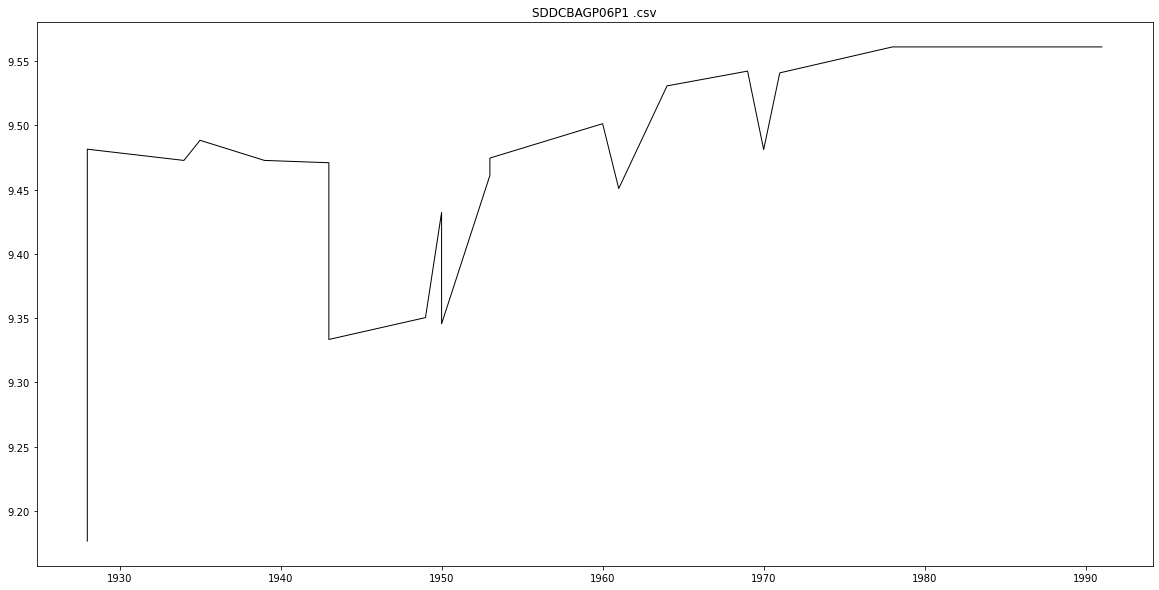

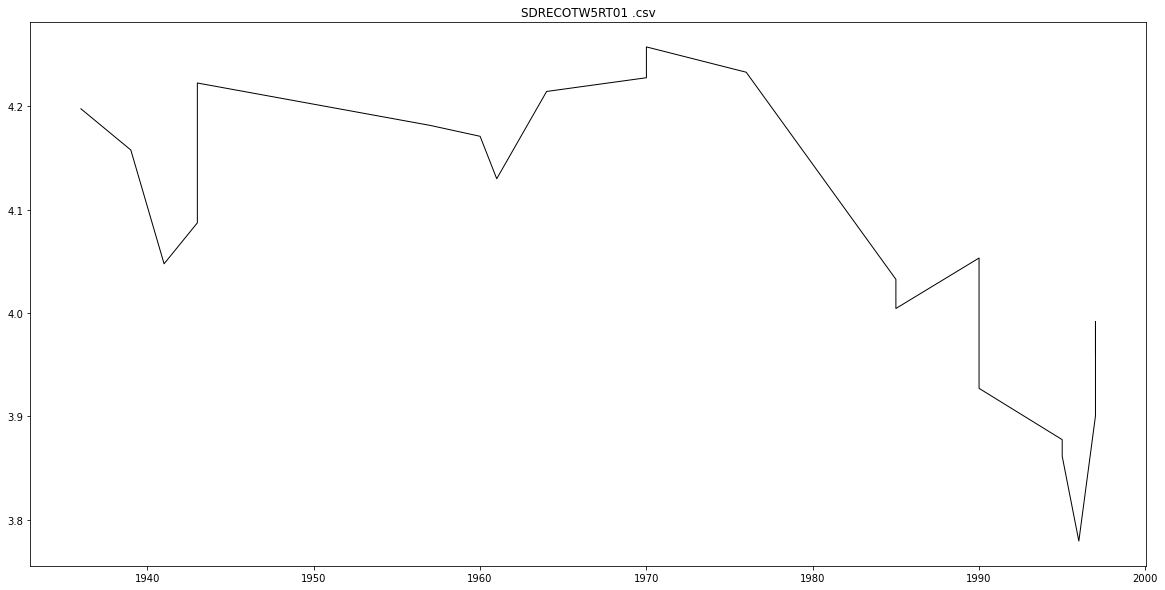

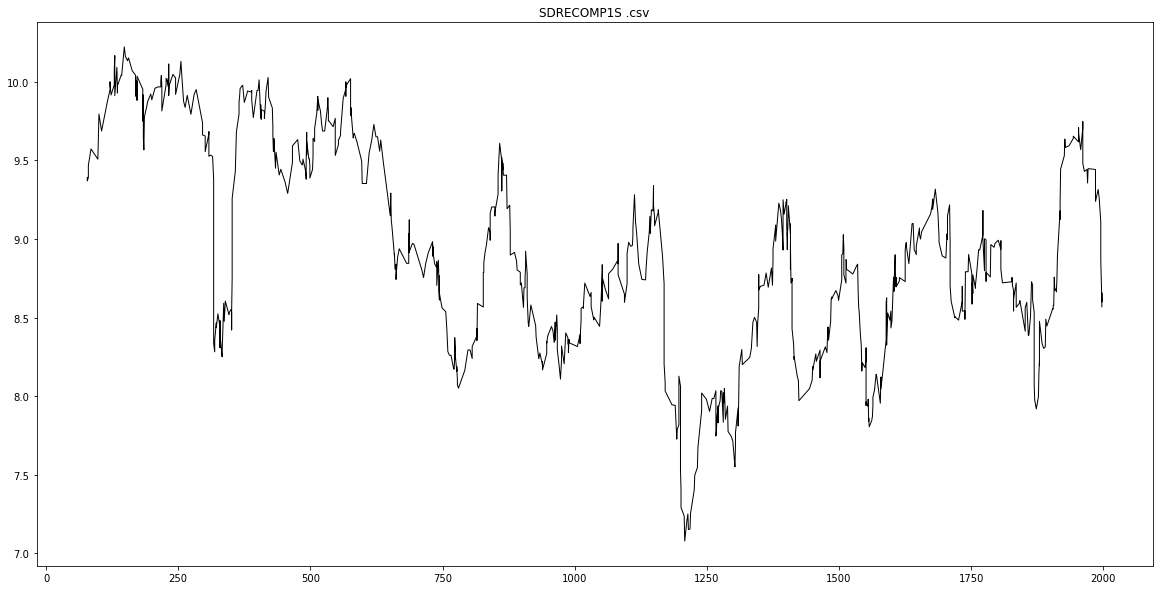

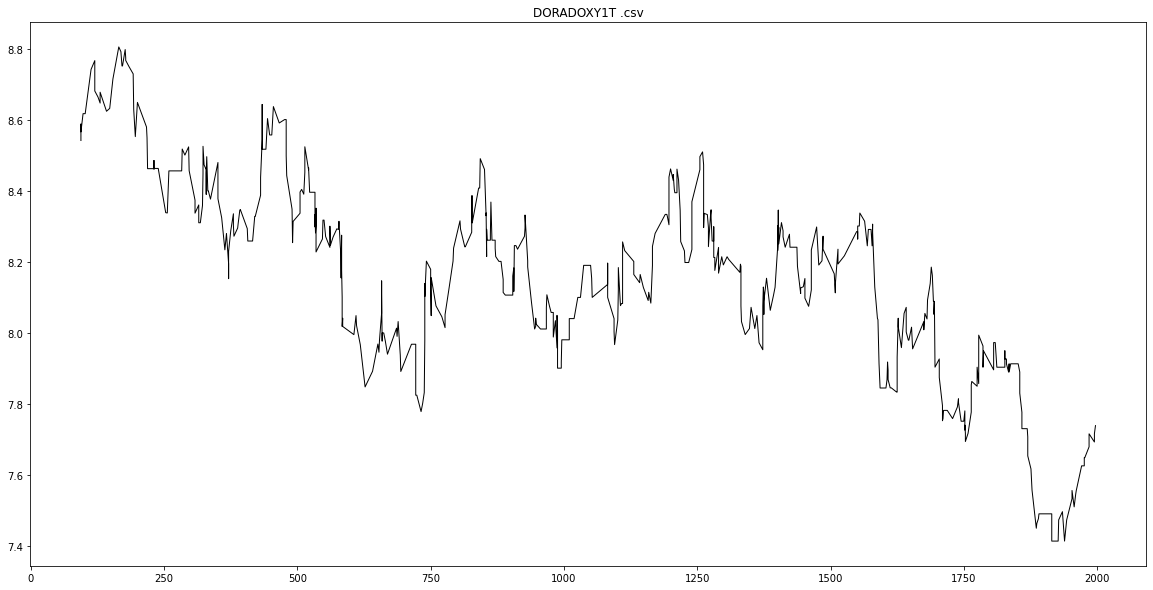

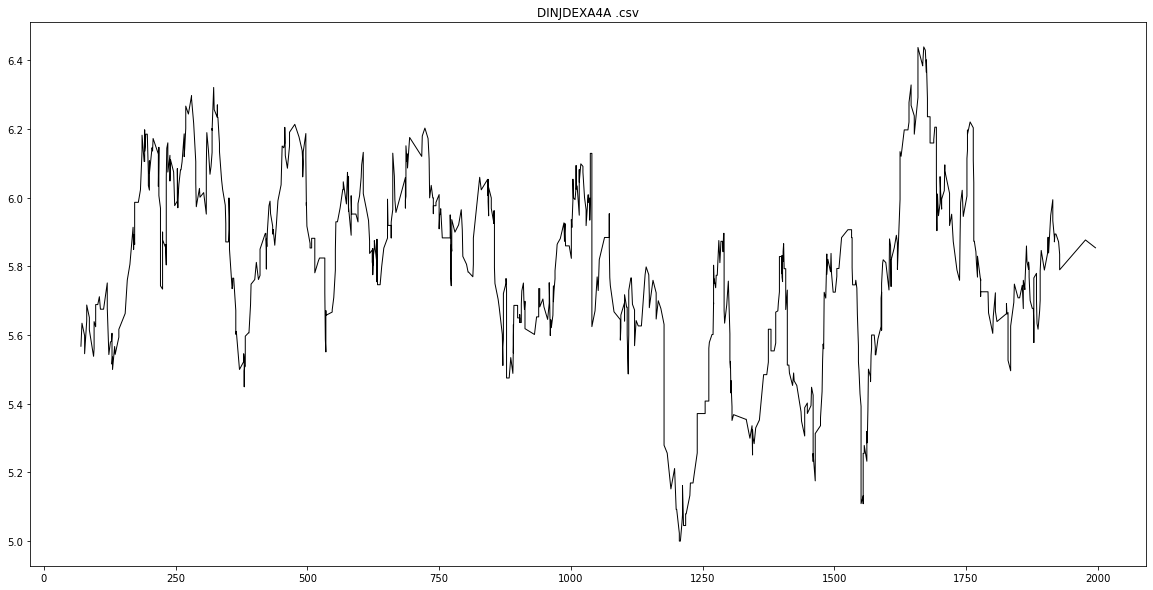

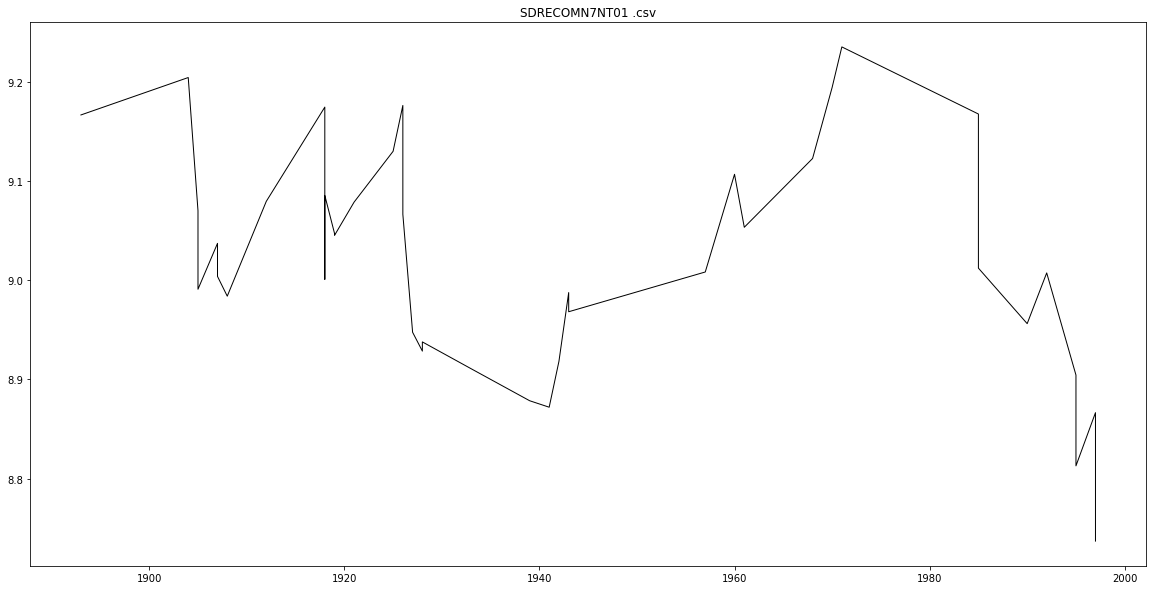

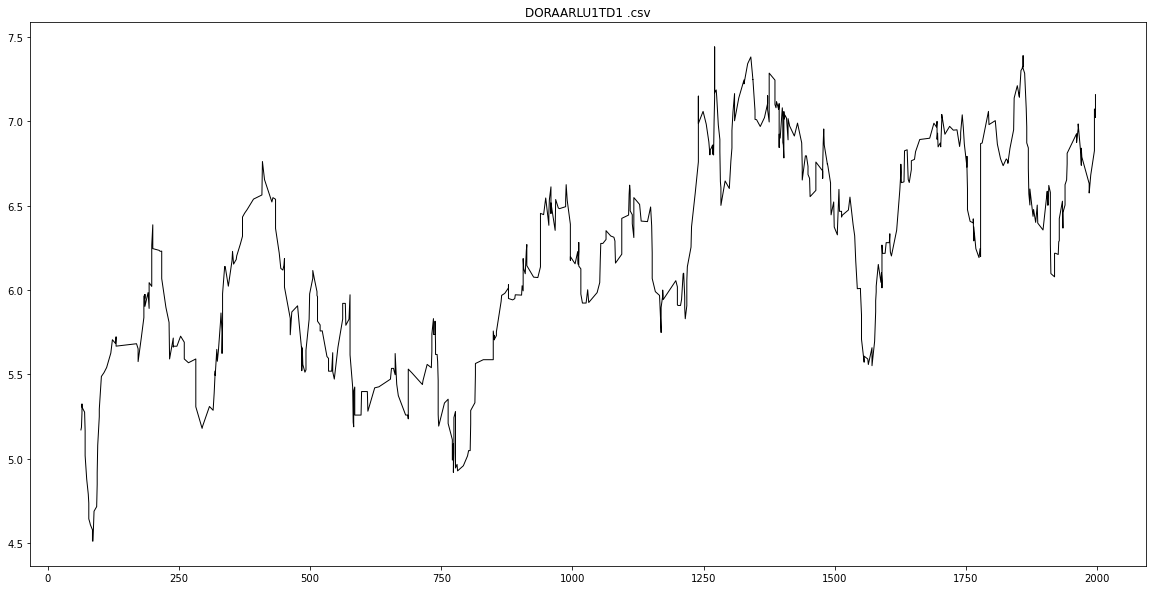

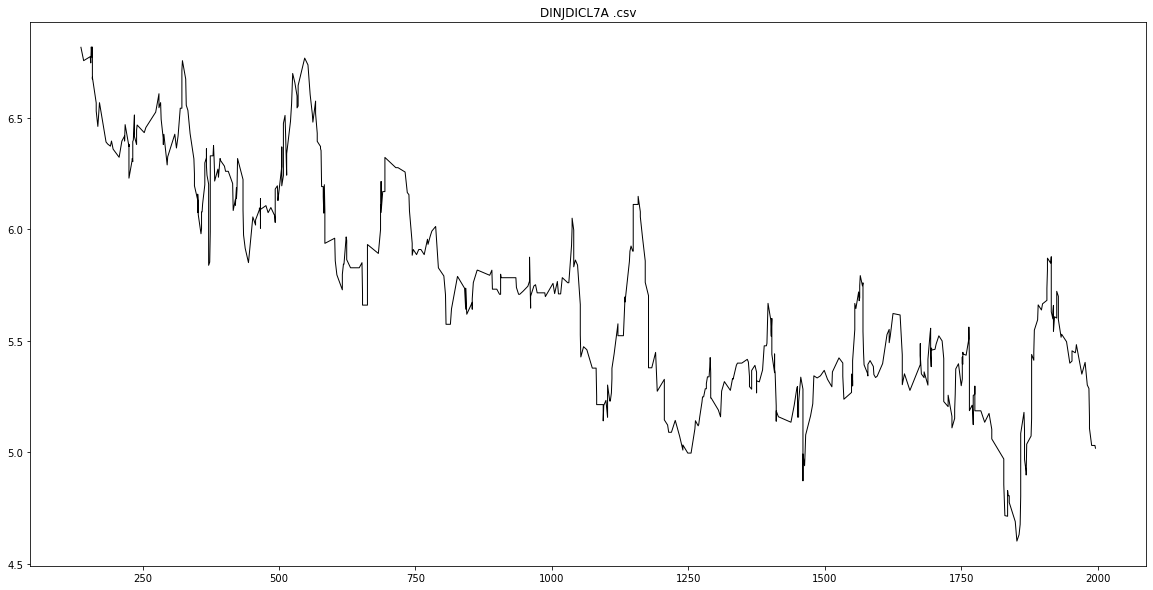

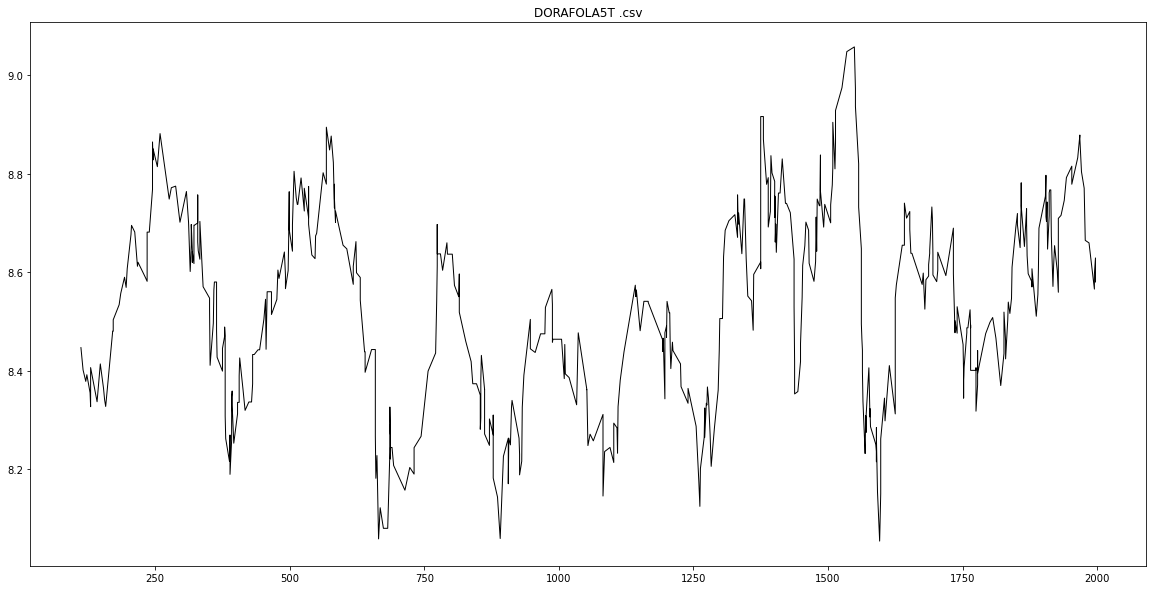

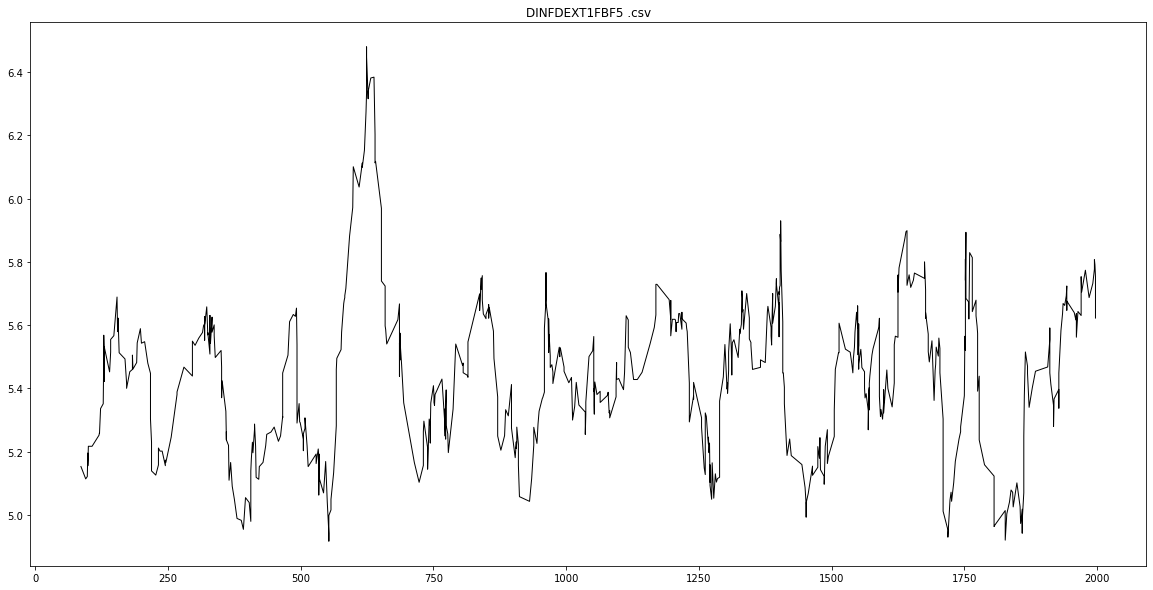

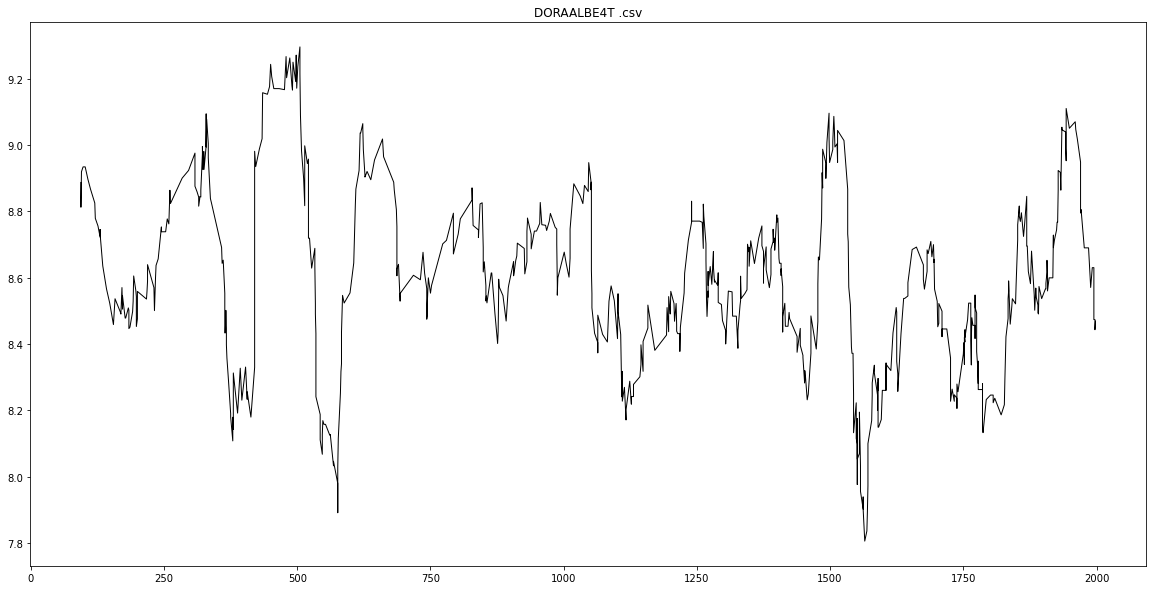

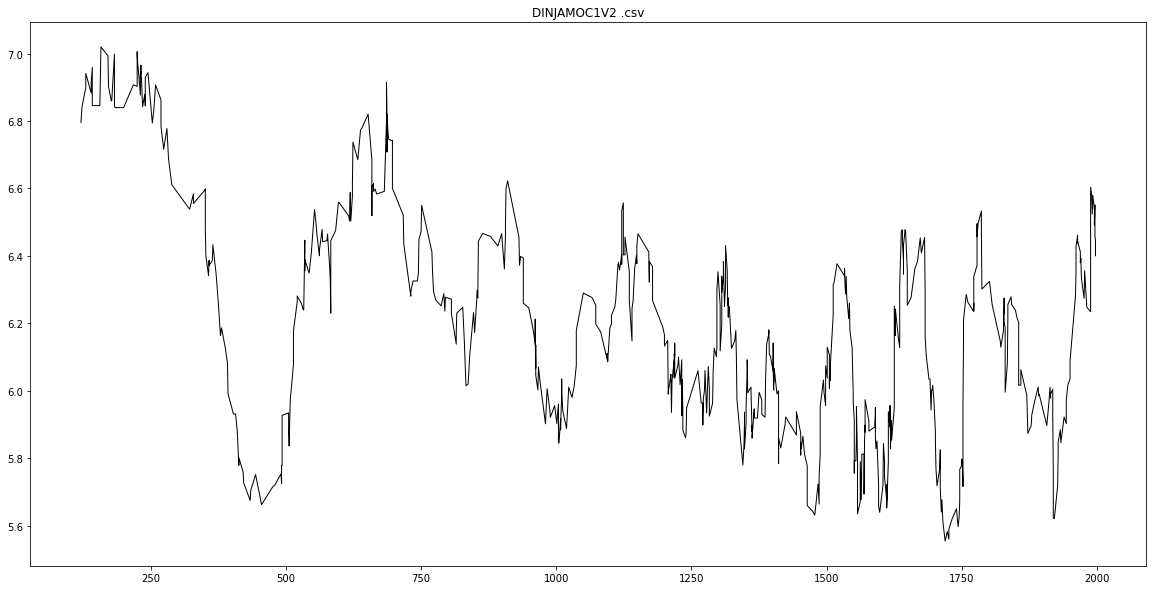

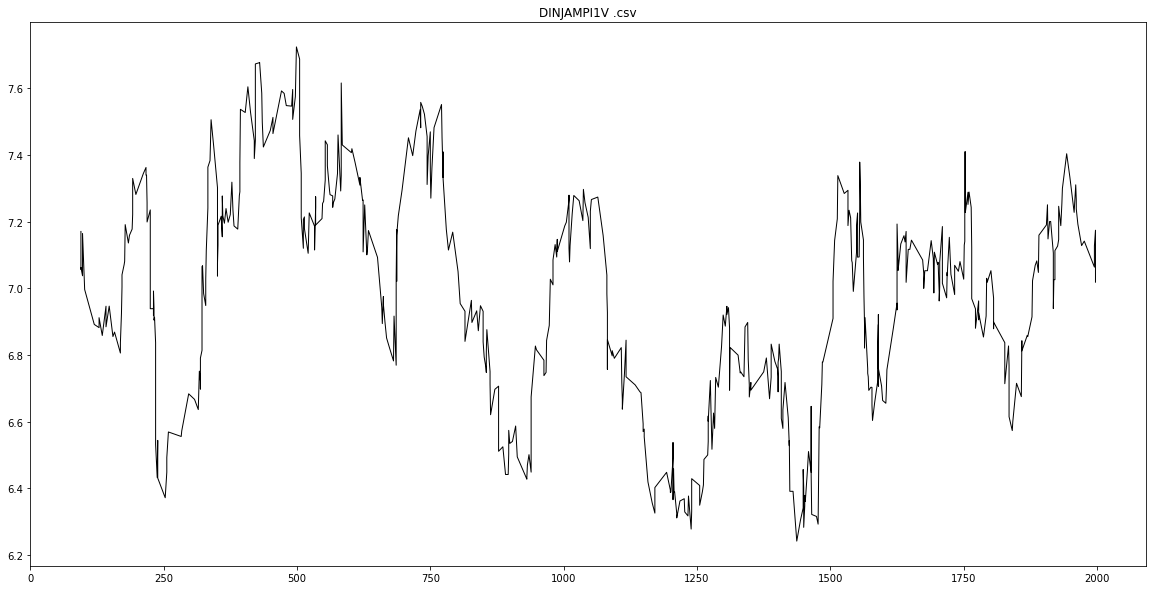

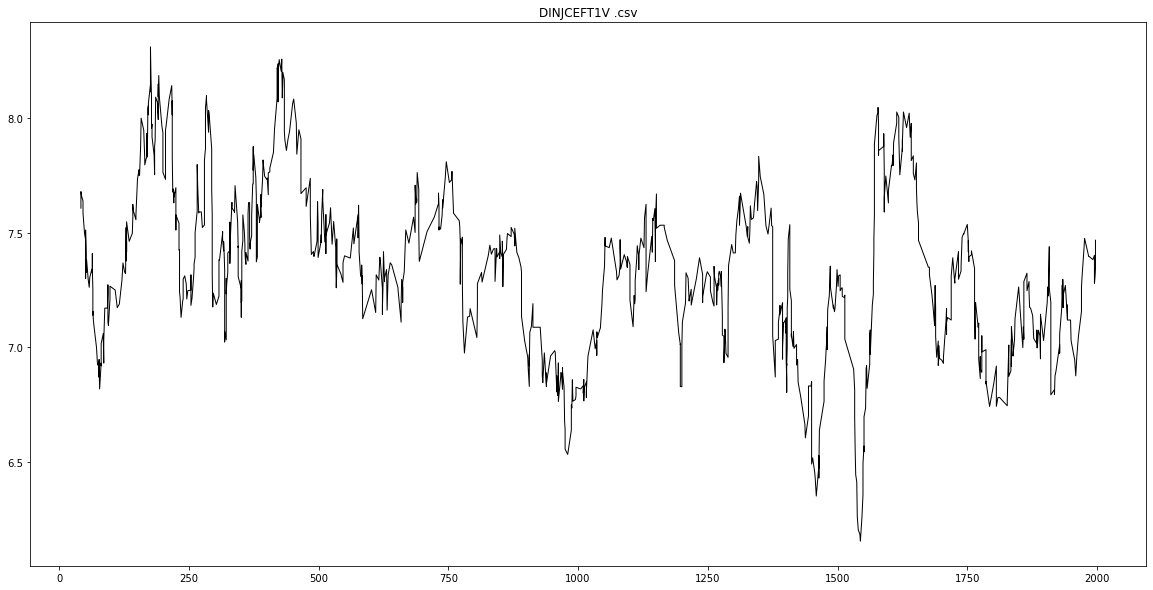

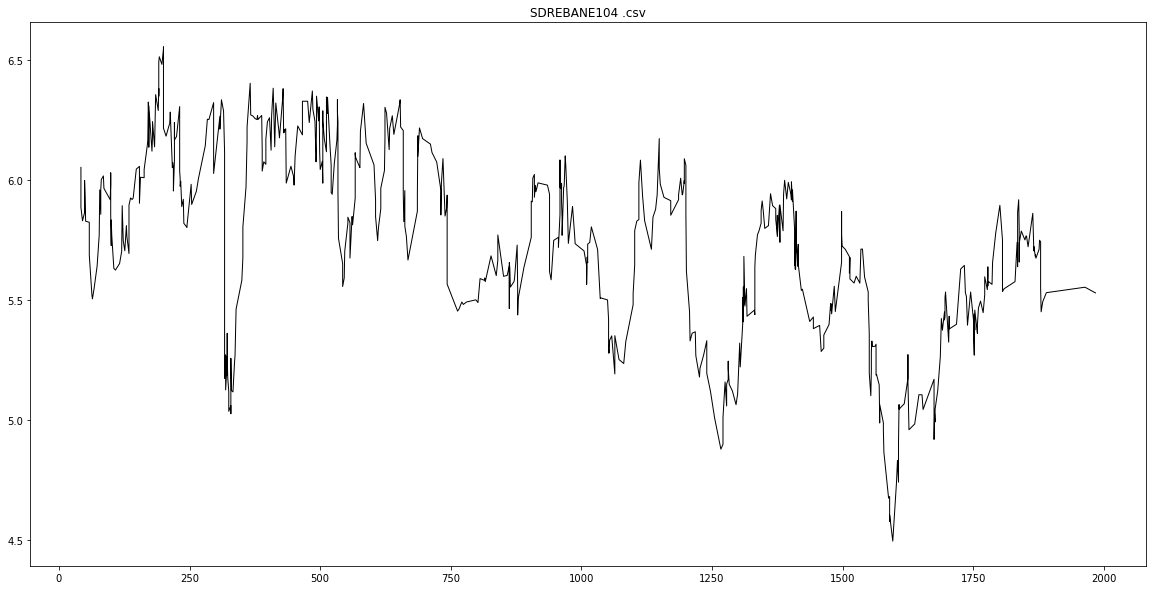

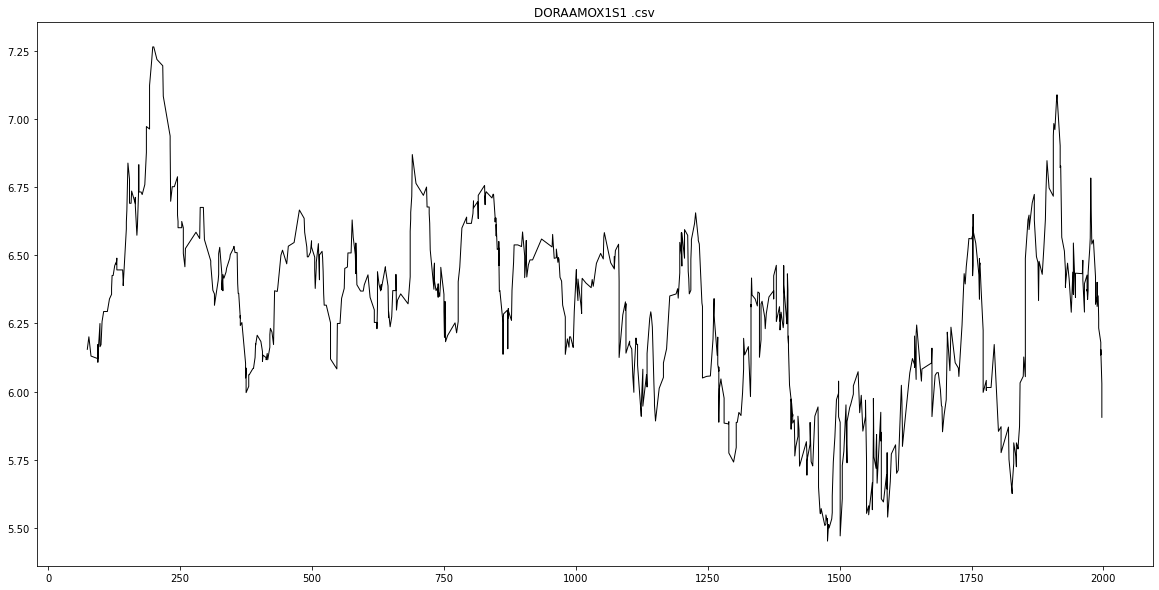

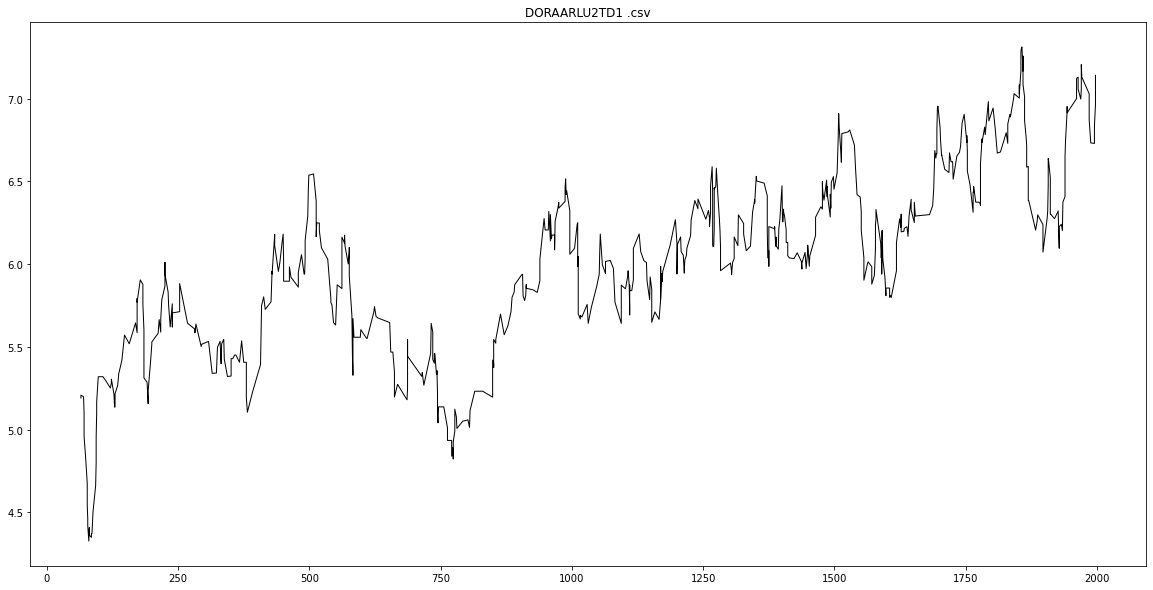

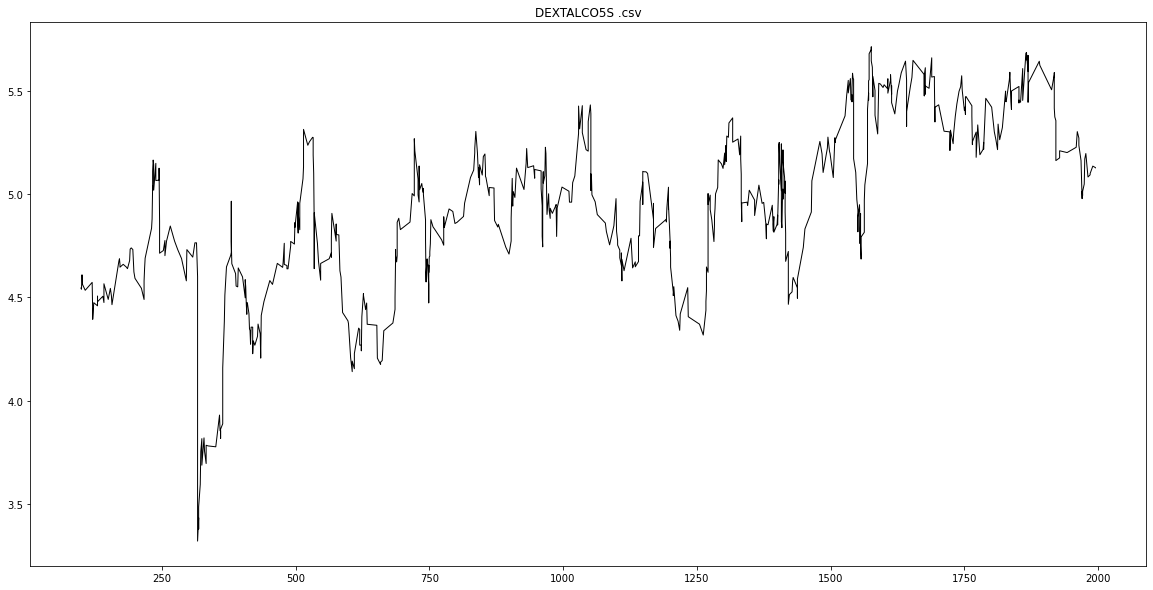

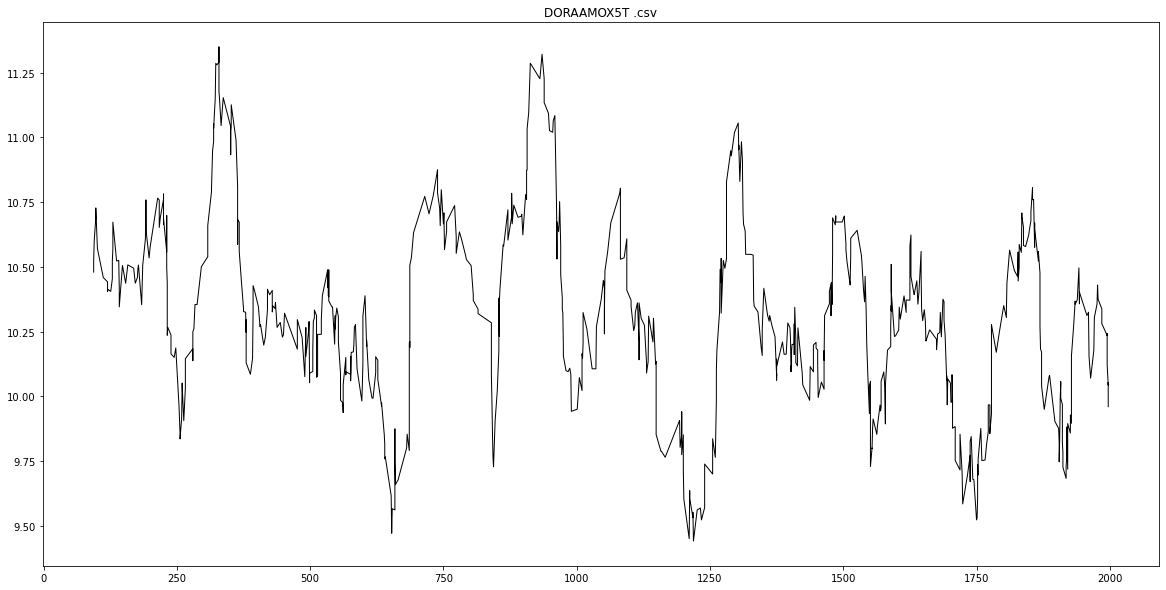

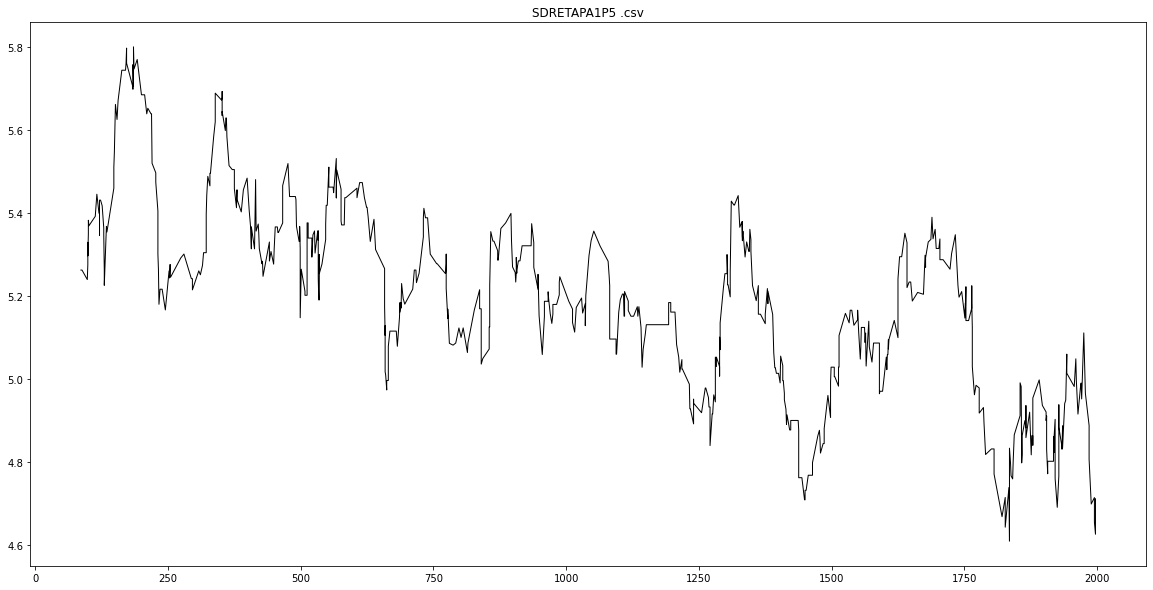

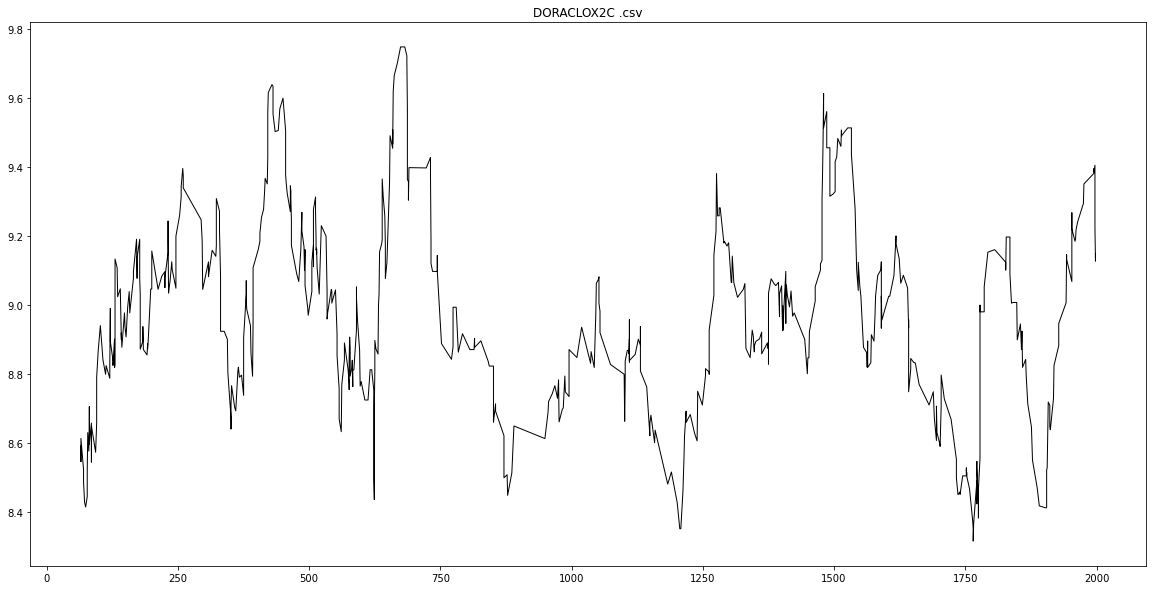

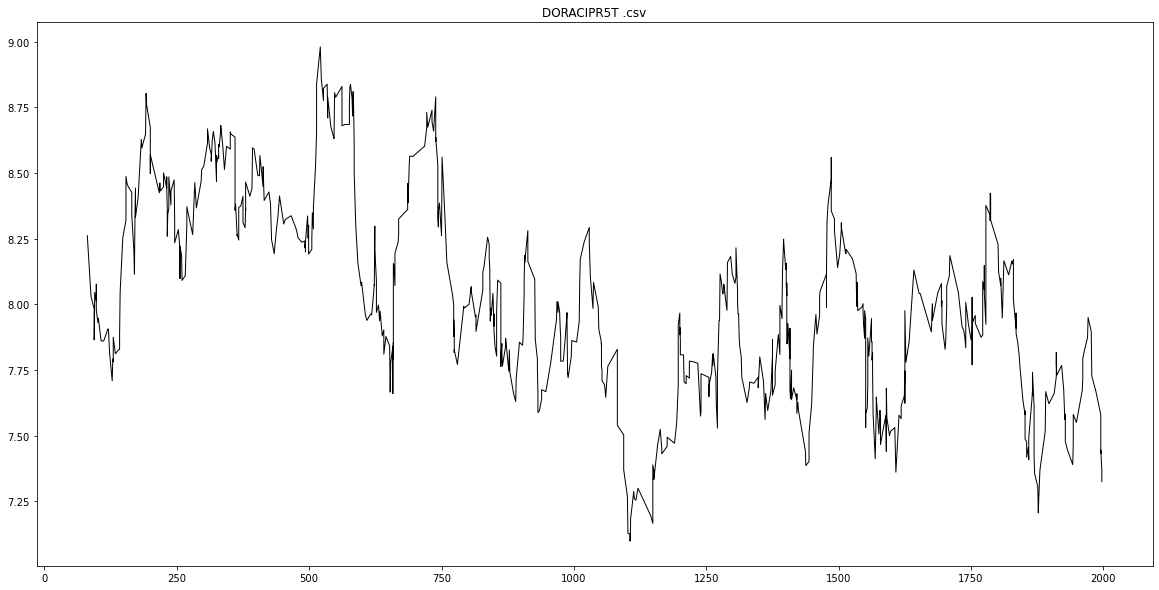

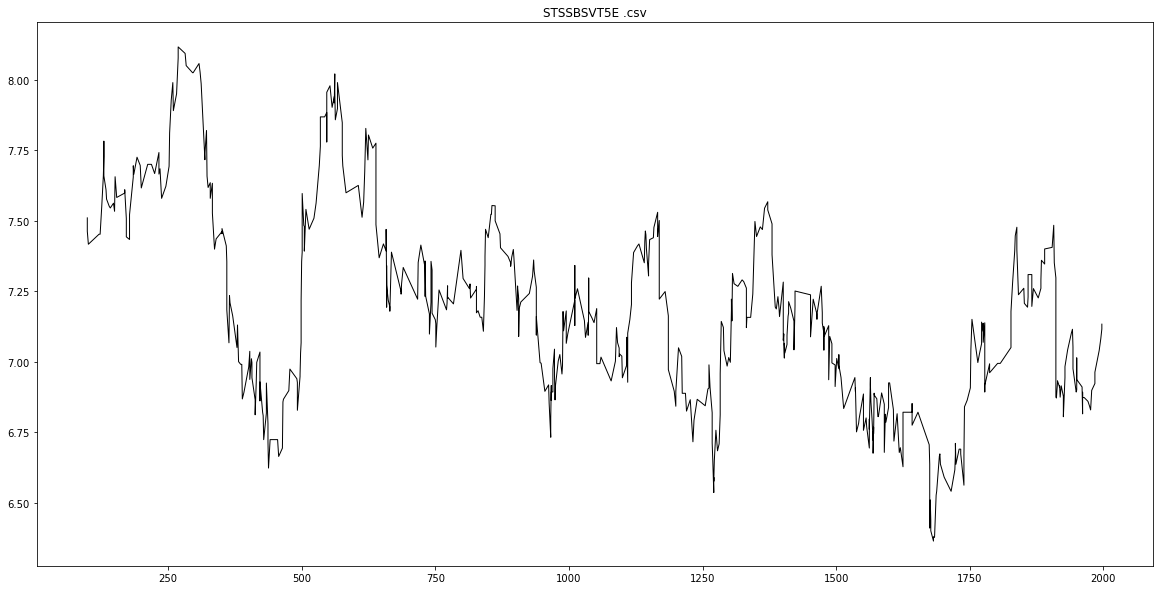

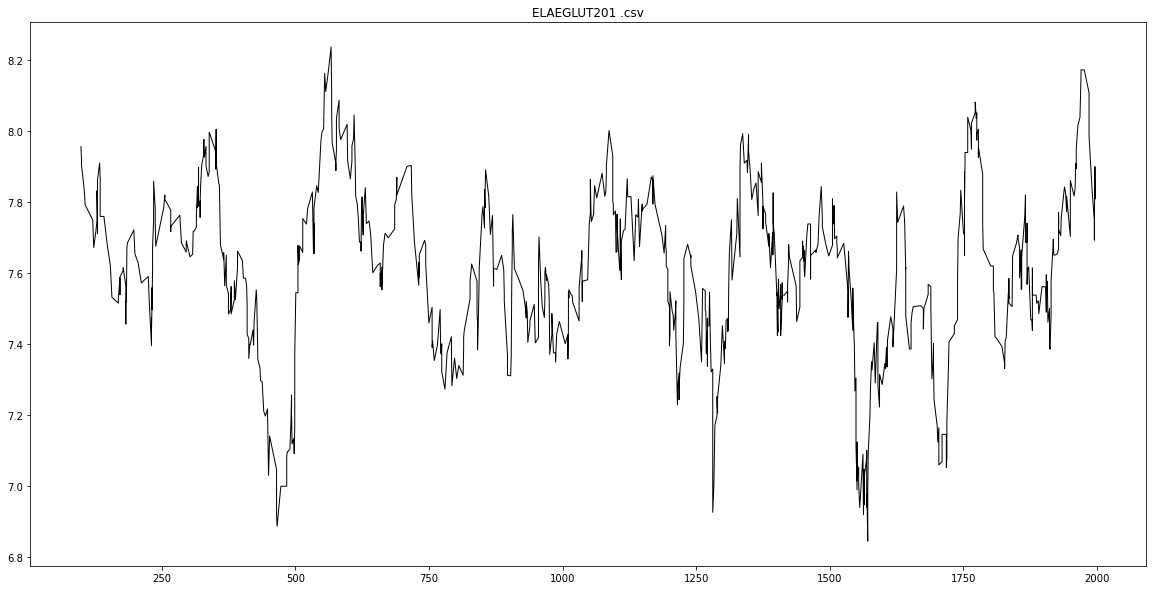

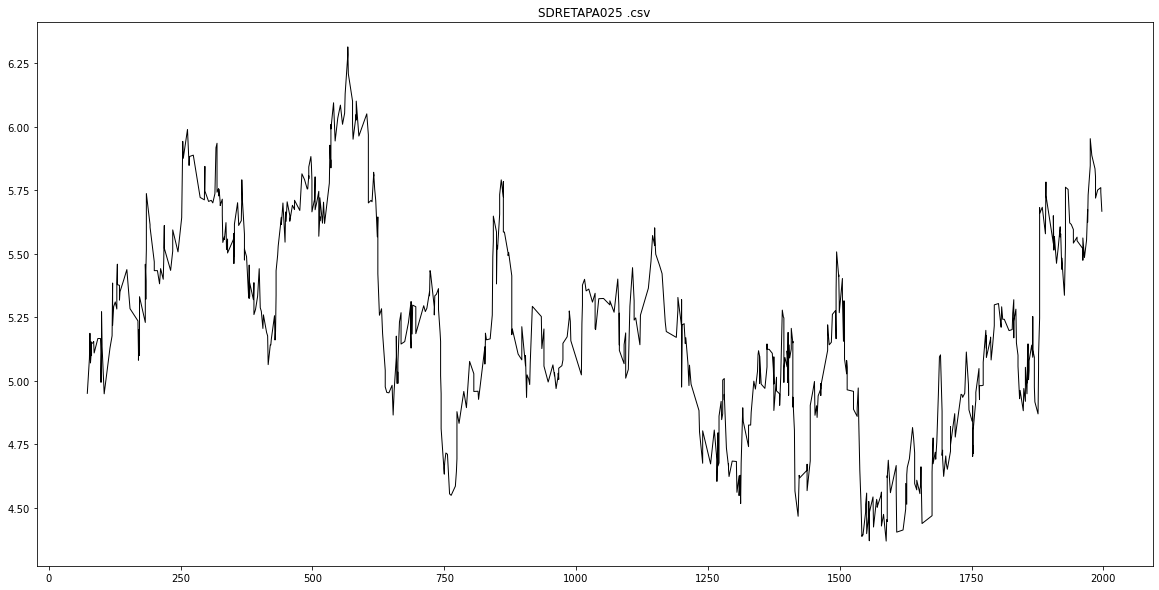

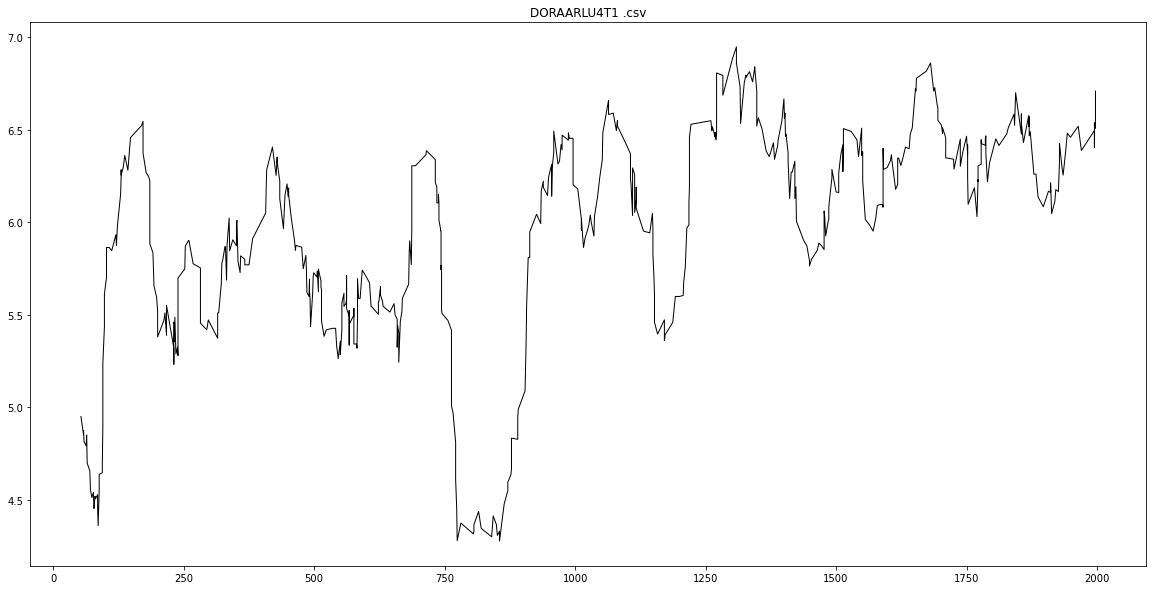

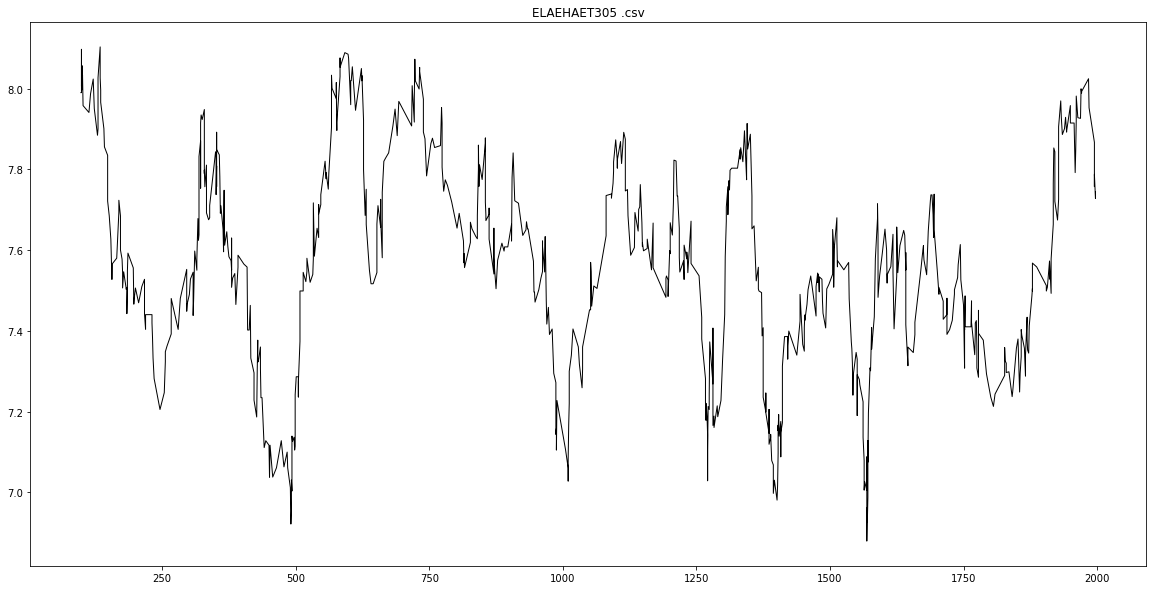

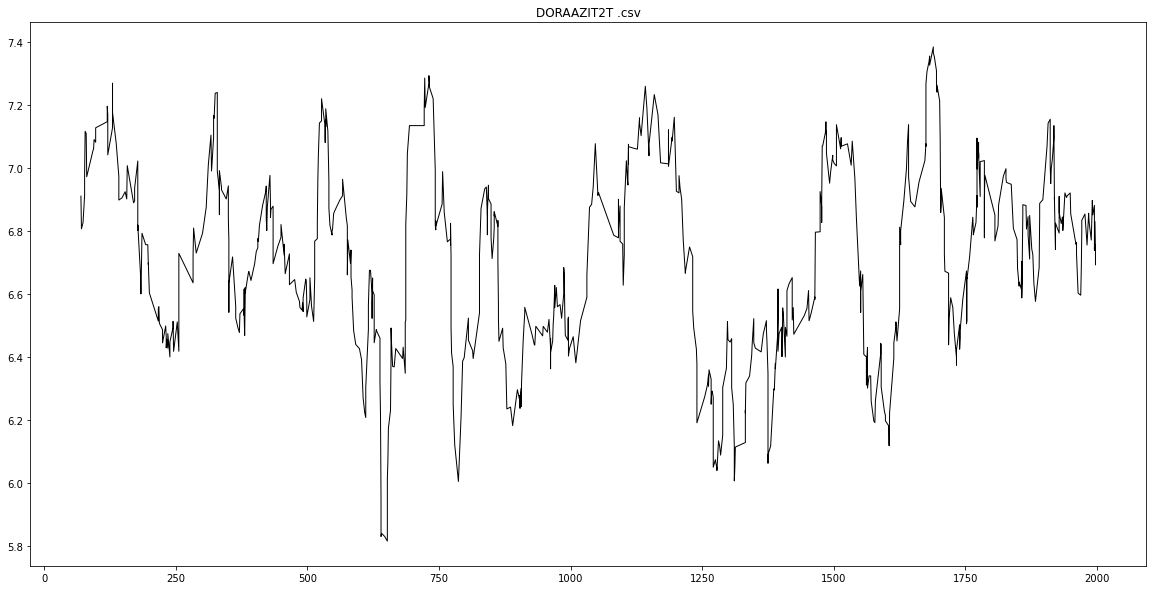

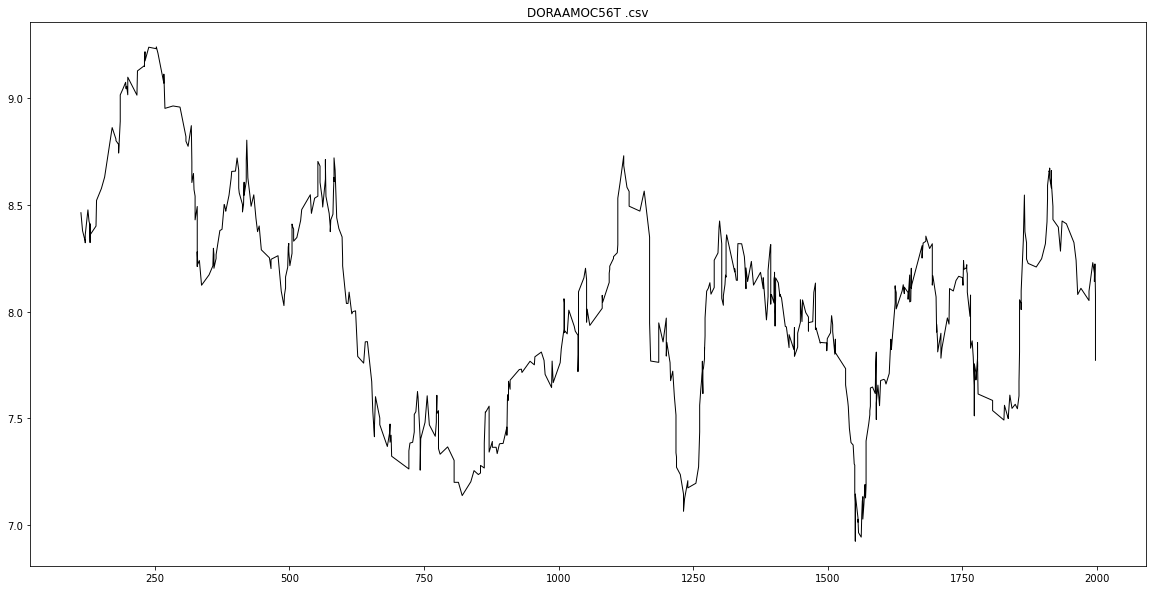

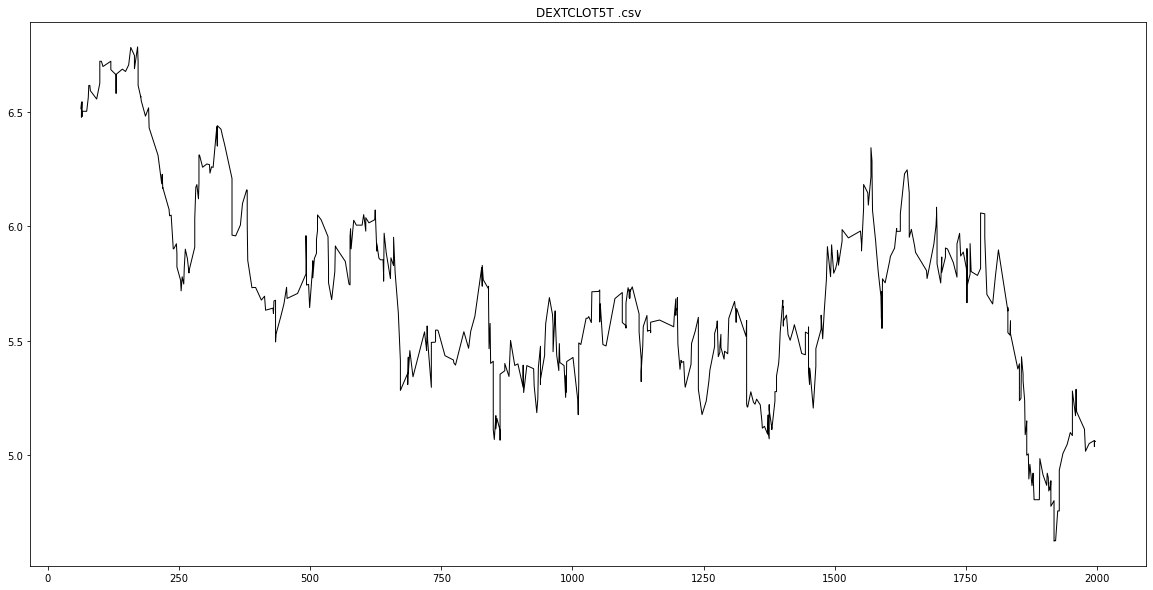

In [34]:
for file in glob.glob("*.csv"):
    df= pd.read_csv(file, parse_dates=False, header=0, usecols=[1,2,3],sep=' ' )
    df=df.sort_values(by=['Numdate'])
    
    X=df['Numdate'].values.reshape(len(df),1)
    Y=df['Logorder'].values.reshape(len(df),1)

    h=30
    Sm=df['Logorder'].rolling(h).sum()/h
    Sl=Sm.values.reshape(len(df),1)
    S=Sl[h:len(Y)]
    X=X[h:len(Y)]
   

    plt.figure(figsize=(20,10))
    plt.plot(X, S,linewidth=1,color='black')
    plt.title(file)

We pick one article we like 

2.17852975495916

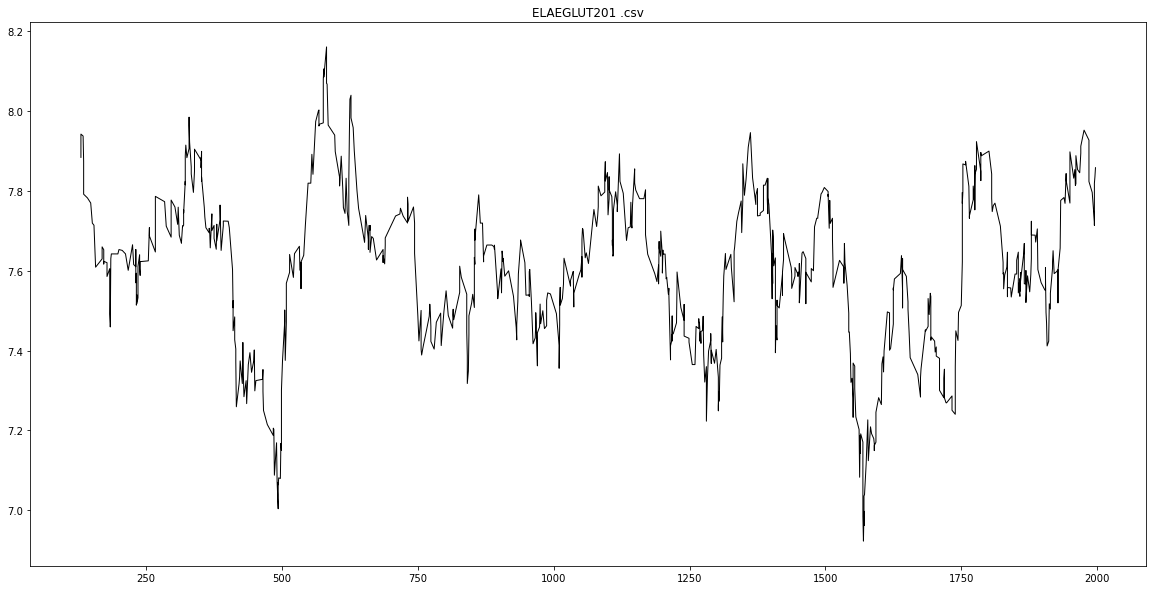

In [166]:
file='ELAEGLUT201 .csv'
df= pd.read_csv(file, parse_dates=False, header=0, usecols=[1,2,3],sep=' ' )
df=df.sort_values(by=['Numdate'])

X=df['Numdate'].values.reshape(len(df),1)
Y=df['Logorder'].values.reshape(len(df),1)

h=40
Sm=df['Logorder'].rolling(h).sum()/h
Sl=Sm.values.reshape(len(df),1)
S=Sl[h:len(Y)]
X=X[h:len(Y)]


plt.figure(figsize=(20,10))
plt.plot(X, S,linewidth=1,color='black')
plt.title(file)



Xf=X.squeeze(-1)
Xf.ndim

Sf=S.squeeze(-1)
Sf.ndim


# shrink stores how many times bigger is the original time domain with respect to the one of the 'homogeneized' series
shrink=(Xf[-1]-Xf[0])/len(Xf)
shrink 








Now let us detrend the data (a deg 3 polynomial spline should be enough)

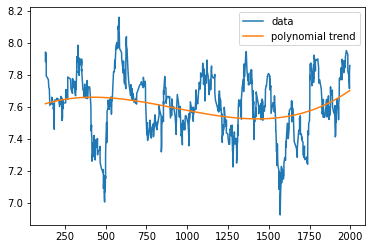

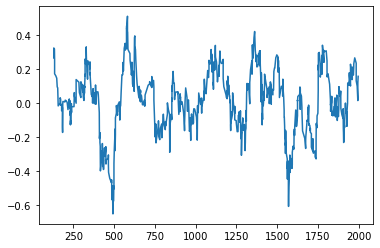

In [167]:
pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(Xf.reshape(-1, 1)) # it is the input shape the library asks you 
md2 = LinearRegression()
md2.fit(Xp, Sf)
trendp = md2.predict(Xp)


plt.plot(Xf, Sf)
plt.plot(Xf, trendp)
plt.legend(['data', 'polynomial trend'])
plt.show()

S=Sf-trendp # zm stands for zero-mean

plt.plot(Xf, S)
plt.show()

We choose the peak frequencies (the 10 with highest complex module)

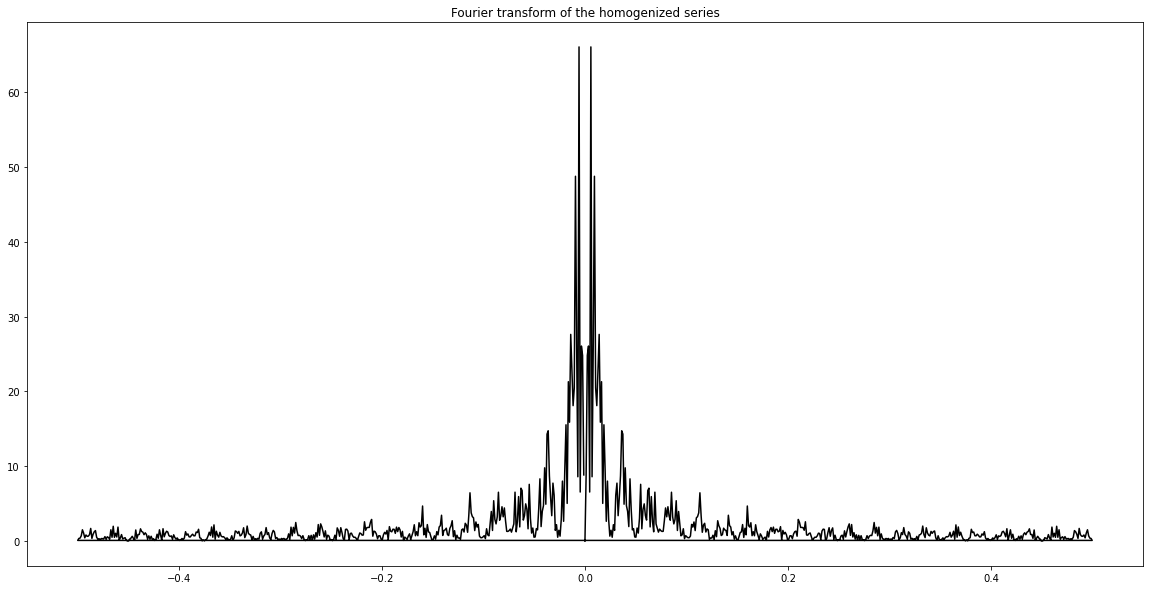

In [168]:
import scipy


yf = np.fft.fft(S)
freq = np.fft.fftfreq(S.shape[-1])

# x-axis are wavenumbers k=2pi/lambda

plt.figure(figsize=(20,10))
plt.plot(freq,abs(yf),color='black')
plt.title('Fourier transform of the homogenized series')
len(yf)

yf2=yf[np.where(freq>0)]
freq2=freq[np.where(freq>0)]

Text(0.5, 1.0, 'Fourier transform of the homogenized series')

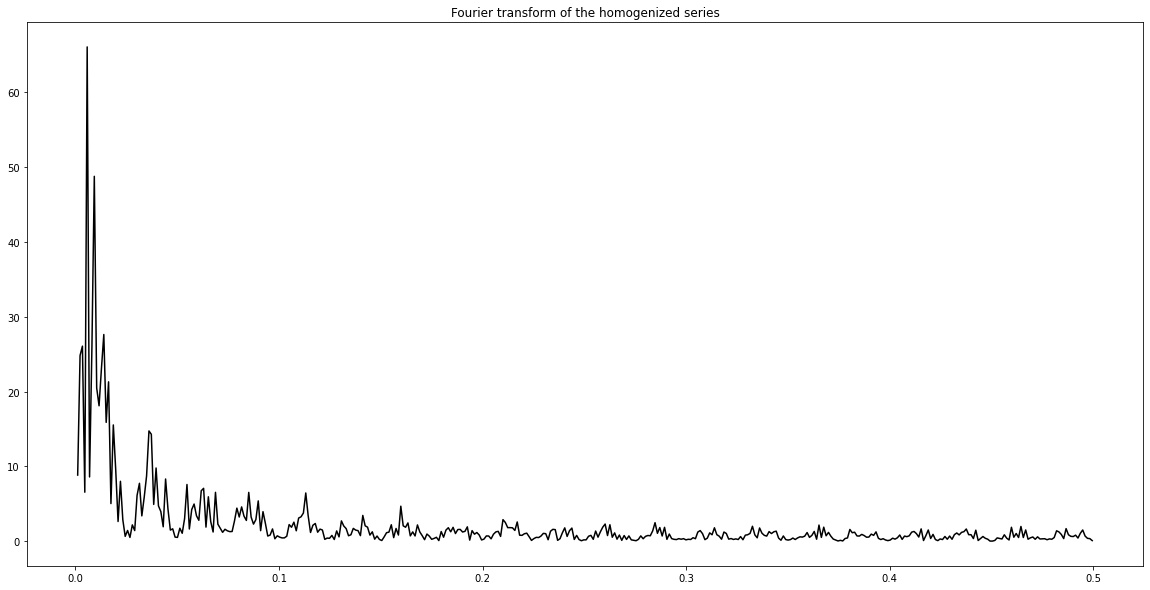

In [169]:
plt.figure(figsize=(20,10))
plt.plot(freq2,abs(yf2),color='black')
plt.title('Fourier transform of the homogenized series')

In [170]:
Ti=abs(shrink/freq2[np.argsort(-abs(yf2))])[range(0,15,1)]
Ti


array([373.4       , 233.375     , 155.58333333, 622.33333333,
       266.71428571, 933.5       , 169.72727273, 133.35714286,
       207.44444444, 186.7       , 143.61538462, 116.6875    ,
        60.22580645,  58.34375   ,  54.91176471])

In [171]:
pastdays=np.flip(np.diff(Xf)).cumsum(axis=0)


In [172]:
res = next(x for x, val in enumerate(pastdays)
                                  if val > 90)
train=range(0,(len(X)-res)) # we choose everything but last 3 months for training

In [173]:
objectives=[]

for T in Ti:

    ker=GPy.kern.StdPeriodic(1,period=T)
    
    m = GPy.models.GPRegression(X[train],S[train].reshape(-1,1),ker)

    # optimize and plot
    m.optimize(messages=True,max_f_eval = 10000)
    print(m)
    
    Yp, Vp = m.predict(X)
    lo, up = m.predict_quantiles(X, quantiles=(2.5, 97.5), Y_metadata=None, kern=None, likelihood=None)

    squ=(S[range(train[-1],len(X))].squeeze()-Yp[range(train[-1],len(X))].squeeze())**2
    #objectives.append(m.log_likelihood())
    objectives.append(np.sum(squ))
    #objectives.append(np.sum(np.square(Szm-Yp)))
    


Name : GP regression
Objective : -329.2348611024169
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |   0.01338158583664223  |      +ve      |        
  std_periodic.period       |    384.18438594800045  |      +ve      |        
  std_periodic.lengthscale  |   0.05416677474713489  |      +ve      |        
  Gaussian_noise.variance   |  0.023026139032181574  |      +ve      |        



Name : GP regression
Objective : -313.93069944010284
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.011624133023797906  |      +ve      |        
  std_periodic.period       |     271.9774891039025  |      +ve      |        
  std_periodic.lengthscale  |   0.24933139410122257  |      +ve      |        
  Gaussian_noise.variance   |   0.02594853234696478  |      +ve      |        



Name : GP regression
Objective : -217.16365410834203
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.006046968041820885  |      +ve      |        
  std_periodic.period       |    153.24626465467318  |      +ve      |        
  std_periodic.lengthscale  |   0.12645134359591864  |      +ve      |        
  Gaussian_noise.variance   |   0.03277491692757098  |      +ve      |        



Name : GP regression
Objective : -363.5923379154812
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.016085087369119105  |      +ve      |        
  std_periodic.period       |     567.5713208416583  |      +ve      |        
  std_periodic.lengthscale  |   0.04267519588228417  |      +ve      |        
  Gaussian_noise.variance   |  0.020402326522731266  |      +ve      |        



Name : GP regression
Objective : -313.9306994403556
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.011624244169745529  |      +ve      |        
  std_periodic.period       |    271.97749190494864  |      +ve      |        
  std_periodic.lengthscale  |   0.24933249787999498  |      +ve      |        
  Gaussian_noise.variance   |  0.025948544711644546  |      +ve      |        


 /home/carlos/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



Name : GP regression
Objective : -341.8023154252774
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.015978262429755776  |      +ve      |        
  std_periodic.period       |     920.7293640255556  |      +ve      |        
  std_periodic.lengthscale  |  0.022178283541162826  |      +ve      |        
  Gaussian_noise.variance   |  0.020147945149337654  |      +ve      |        



Name : GP regression
Objective : -165.8055002050162
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  std_periodic.variance     |  7.915239311261916e-10  |      +ve      |        
  std_periodic.period       |     193.93100700671351  |      +ve      |        
  std_periodic.lengthscale  |     26.858143067244026  |      +ve      |        
  Gaussian_noise.variance   |    0.03899729282612288  |      +ve      |        



Name : GP regression
Objective : -208.4954568368039
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.006373244659122958  |      +ve      |        
  std_periodic.period       |     133.9903137931808  |      +ve      |        
  std_periodic.lengthscale  |    0.6283272697368587  |      +ve      |        
  Gaussian_noise.variance   |   0.03447560157203534  |      +ve      |        


 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:divide by zero encountered in true_divide
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:invalid value encountered in true_divide
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:168: RuntimeWarning:invalid value encountered in multiply



Name : GP regression
Objective : -362.76920405064135
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                   value  |  constraints  |  priors
  std_periodic.variance     |     0.04232277040402149  |      +ve      |        
  std_periodic.period       |      207.32294401382273  |      +ve      |        
  std_periodic.lengthscale  |  1.1205688701111763e-06  |      +ve      |        
  Gaussian_noise.variance   |    0.013014481706266607  |      +ve      |        



Name : GP regression
Objective : -550.4669011359604
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                   value  |  constraints  |  priors
  std_periodic.variance     |    0.038053000266724785  |      +ve      |        
  std_periodic.period       |       190.8360276613155  |      +ve      |        
  std_periodic.lengthscale  |  3.3375955717278026e-06  |      +ve      |        
  Gaussian_noise.variance   |   0.0016452503794879235  |      +ve      |        



Name : GP regression
Objective : -225.1216388377103
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |  0.009443982161766245  |      +ve      |        
  std_periodic.period       |    153.11138496731334  |      +ve      |        
  std_periodic.lengthscale  |   0.01955059462612613  |      +ve      |        
  Gaussian_noise.variance   |  0.028905020959005285  |      +ve      |        


 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:divide by zero encountered in true_divide
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in multiply
 /home/carlos/anaconda3/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:163: RuntimeWarning:invalid value encountered in multiply



Name : GP regression
Objective : -172.48519228684654
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |   0.00445664576181929  |      +ve      |        
  std_periodic.period       |    118.76415511567792  |      +ve      |        
  std_periodic.lengthscale  |    0.6137970641051043  |      +ve      |        
  Gaussian_noise.variance   |  0.034416809636714556  |      +ve      |        



Name : GP regression
Objective : -168.23119592102438
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  std_periodic.variance     |  0.0005106938640069841  |      +ve      |        
  std_periodic.period       |      59.68189296261104  |      +ve      |        
  std_periodic.lengthscale  |    0.36574075455153926  |      +ve      |        
  Gaussian_noise.variance   |    0.03848747476940215  |      +ve      |        



Name : GP regression
Objective : -550.466901136012
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  std_periodic.variance     |    0.03805297686066684  |      +ve      |        
  std_periodic.period       |      60.83686252193357  |      +ve      |        
  std_periodic.lengthscale  |  7.328685656947374e-21  |      +ve      |        
  Gaussian_noise.variance   |  0.0016452503857512196  |      +ve      |        



Name : GP regression
Objective : -165.80550420842565
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                   value  |  constraints  |  priors
  std_periodic.variance     |  3.4254724144453366e-10  |      +ve      |        
  std_periodic.period       |       49.16584780707849  |      +ve      |        
  std_periodic.lengthscale  |      11.667041727431332  |      +ve      |        
  Gaussian_noise.variance   |     0.03899728051691179  |      +ve      |        


In [174]:
objectives

[2.9822611128823855,
 1.1225423923985975,
 0.64975726816621,
 0.7983039141394161,
 1.1225421604770303,
 0.5057978202234378,
 0.932126465869973,
 1.8106493474047254,
 0.9030164495540203,
 0.9013649807653347,
 0.930986086018209,
 0.880924927334988,
 0.8807991734258921,
 0.9013649808281325,
 0.9321263641427554]

In [175]:
ker=GPy.kern.StdPeriodic(1,period=Ti[np.argmin(objectives)])#+GPy.kern.StdPeriodic(1,period=Ti[4])+GPy.kern.StdPeriodic(1,period=Ti[2])


m = GPy.models.GPRegression(X[train],S[train].reshape(-1,1),ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 10000)


Yp, Vp = m.predict(X)
lo, up = m.predict_quantiles(X, quantiles=(2.5, 97.5), Y_metadata=None, kern=None, likelihood=None)



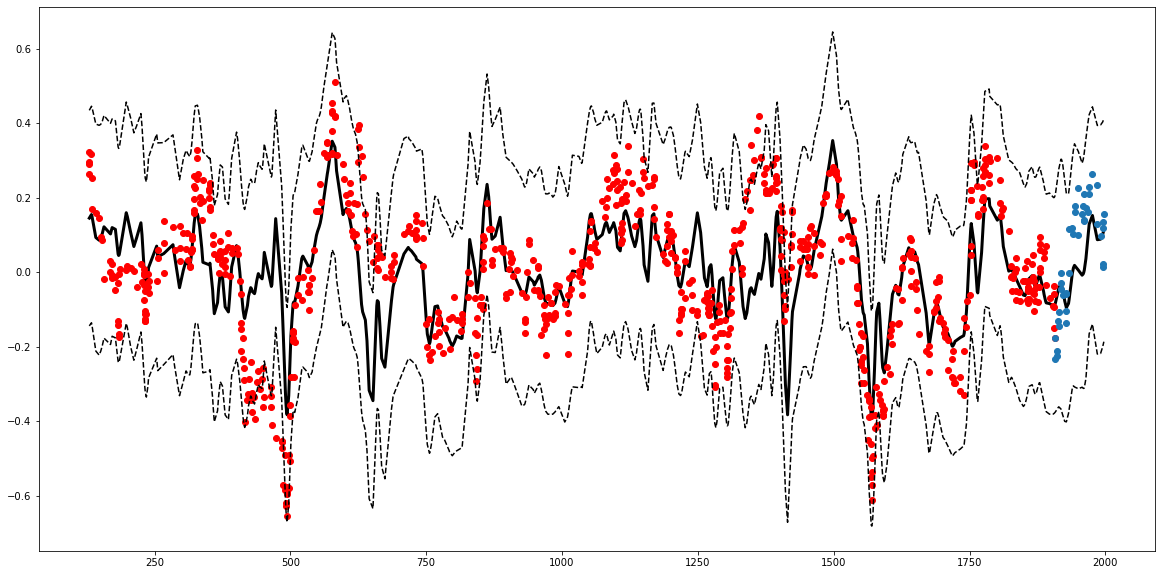

In [176]:
plt.figure(figsize=(20,10))
plt.plot(X,Yp,'black',linewidth=3)
plt.plot(X[train], S[train], "or")
plt.plot(X[train[-1]:len(X)], S[train[-1]:len(X)], "o")
plt.plot(X,lo,'--',color='black')
plt.plot(X,up,'--',color='black')